In [1]:
import sympy as sp
from lbmpy.stencils import LBStencil, Stencil
from lbmpy.moments import MOMENT_SYMBOLS, moment_matrix
import numpy as np
from numpy import fft
from sympy.plotting import plot
import yt
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Validating cholesky decomposition

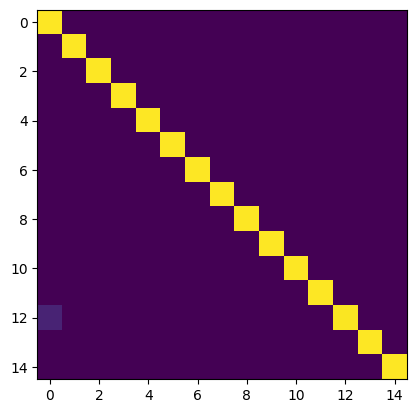

In [46]:
n = 19
test1 = np.eye(n)

for i in range(4):
    test1[i, i] = 0

test1[16, 4] = 0.1
test1[4, 16] = 0.1

sample = test1[4:, 4:]

L1 = np.linalg.cholesky(sample)
test1[4:, 4:] = L1

plt.imshow(L1)

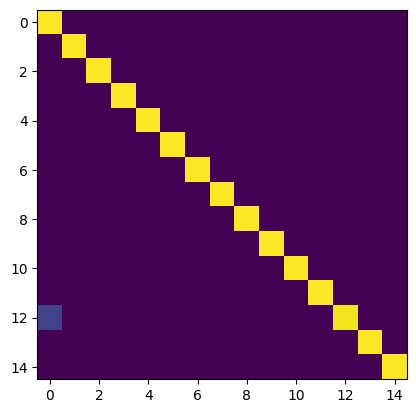

In [47]:
n = 19
test2 = np.eye(n)

for i in range(4):
    test2[i, i] = 0

test2[16, 4] = 0.2
test2[4, 16] = 0.2

sample = test2[4:, 4:]

L2 = np.linalg.cholesky(sample)
test2[4:, 4:] = L2

plt.imshow(L2)

In [48]:
# as implemented in code


def cholesky_decomp(arr_in, n, bstart):
    A = arr_in.copy()
    # sum = 0
    for i in range(bstart, n):
        for j in range(bstart, i + 1):
            sum = A[i*n + j]
            for k in range(j - 1, bstart - 1, -1):
                sum -= A[i*n+k]*A[j*n+k]
            if i == j:
                if sum >= 0:
                    A[i*n+j] = np.sqrt(sum)
                else:
                    A[i*n+j] = 0
                    print(f"Row {i} in matrix not spd!")
            else:
                if A[j*n+j] > 0:
                    A[i*n+j] = sum/A[j*n+j]
                else:
                    print("Should not reach here")

    for i in range(0, n):
        for j in range(i + 1, n):
            A[i*n+j] = 0

    return A

In [49]:
arr_in = np.zeros((19, 19))
B = np.zeros((19, 19))

arr_in[4, 4] = 5.0813e-7
arr_in[5, 5] = 4e-7
arr_in[6, 6] = 1.33e-7
arr_in[7, 7] = 3.33e-8
arr_in[8, 8] = arr_in[7, 7]
arr_in[9, 9] = arr_in[7, 7]
arr_in[10, 10] = 2e-7
arr_in[11, 11] = arr_in[10, 10]
arr_in[12, 12] = arr_in[10, 10]
arr_in[13, 13] = 6.667e-8
arr_in[14, 14] = arr_in[13, 13]
arr_in[15, 15] = arr_in[13, 13]
arr_in[16, 16] = 9.0813e-7
arr_in[17, 17] = 4e-7
arr_in[18, 18] = 1.33e-7

arr_in[4, 16] = -3.0813e-7
arr_in[16, 4] = arr_in[16, 4]

L = np.linalg.cholesky(arr_in[4:, 4:])
B[4:, 4:] = L
L_code = cholesky_decomp(arr_in.flatten(), 19, 4).reshape(19, 19)

In [50]:
B.diagonal(), B[4, 16]

(array([0.        , 0.        , 0.        , 0.        , 0.00071283,
        0.00063246, 0.00036469, 0.00018248, 0.00018248, 0.00018248,
        0.00044721, 0.00044721, 0.00044721, 0.00025821, 0.00025821,
        0.00025821, 0.00095296, 0.00063246, 0.00036469]),
 0.0)

In [51]:
L_code.diagonal(), L_code[4, 16]

(array([0.        , 0.        , 0.        , 0.        , 0.00071283,
        0.00063246, 0.00036469, 0.00018248, 0.00018248, 0.00018248,
        0.00044721, 0.00044721, 0.00044721, 0.00025821, 0.00025821,
        0.00025821, 0.00095296, 0.00063246, 0.00036469]),
 0.0)

# Validating thermodynamic model

## Model quantities

In [106]:
B = sp.symbols("beta")
rho0, rho, rho_v, rho_l = sp.symbols("rho_0 rho rho_v rho_l")
f0 = B*((rho - rho_v)**2)*((rho - rho_l)**2)
cs = sp.symbols("c_s")

mu0 = sp.Derivative(f0, rho).doit()
p0 = sp.simplify(rho*mu0 - f0)
non_ideal_cs2 = sp.simplify(sp.Derivative(p0, rho))

In [108]:
non_ideal_cs2

-beta*(rho - rho_l)*(rho - rho_v)*(-6*rho + rho_l + rho_v) - beta*(rho - rho_l)*(2*rho*(-2*rho + rho_l + rho_v) + (rho - rho_l)*(rho - rho_v)) - beta*(rho - rho_v)*(2*rho*(-2*rho + rho_l + rho_v) + (rho - rho_l)*(rho - rho_v))

In [54]:
# a, b, n, T = sp.symbols("a, b, n , T")
# psi = n*T*sp.ln(n/(1 - n*b)) - a*n**2

# p0 = n*sp.Derivative(psi, n).doit() - psi
# p0

## Surface tension

In [55]:
save_dir = "./surface_tension/"
test = os.path.exists(save_dir)

kappa = 0.03
beta = 0.015
rhov = 0.1
rhol = 1.0
L = 64

In [56]:
if test:
    ts = yt.load(save_dir + "hydro_plt*")
    ds = ts[-1]
    ad = ds.all_data()

    conserved_variables = [('boxlib', 'rho'), ('boxlib', 'ux'), ('boxlib', 'uy'), ('boxlib', 'uz'),
                        ('boxlib', 'pxx'), ('boxlib', 'pyy'), ('boxlib', 'pzz'),
                        ('boxlib', 'pxy'), ('boxlib', 'pxz'), ('boxlib', 'pyz')]

    rho = ad[conserved_variables[0]].reshape((L, L, L))
    # plt.imshow(rho[:, :, L//2], cmap = 'bwr')
    # plt.colorbar()

    slc = slice(L//4, L//2 + L//4)
    rho_slc = rho[slc, L//2, L//2]
    rho_slc = rho_slc.astype(float)
    # plt.plot(rho_slc)

    sigma_theory = ((rhol - rhov)**3)/6*np.sqrt(2*kappa*beta)
    sigma_real = float(np.sum(np.gradient(rho_slc)**2)*kappa)

    print(f"sigma theory: {sigma_theory:.3e}")
    print(f"sigma real  : {sigma_real:.3e}")

yt : [INFO     ] 2024-07-22 21:57:37,513 Parameters: current_time              = 10000.0
yt : [INFO     ] 2024-07-22 21:57:37,514 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-07-22 21:57:37,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-22 21:57:37,516 Parameters: domain_right_edge         = [1. 1. 1.]


sigma theory: 3.645e-03
sigma real  : 3.548e-03


Difference observed is most likely due to discretization issues. If a larger system and longer equilibration time were run, the surface tension would be a closer match

## Interface width

In [57]:
from scipy.optimize import curve_fit

if test:
    width_theory = np.sqrt(8*kappa/beta)*1/(rhol - rhov)

    def fit_func(x, a, b, c, d):
        return a/(b + np.exp(d*(x - c)))

    to_fit = (rho_slc - rhov)/(rhol - rhov)
    x = np.linspace(0, to_fit.size - 1, to_fit.size)
    popt, pcov = curve_fit(fit_func, x, to_fit)

    width_real = popt[0]

    print(f"width theory: {width_theory:.3f}")
    print(f"width real  : {width_real:.3f}")

width theory: 4.444
width real  : 4.891


# Direct application of what I think is happening in gross 2010 paper

## Moment matrix

In [58]:
d3q19 = LBStencil(Stencil.D3Q19)
D = len(d3q19[0])
Q = len(d3q19)
c = sp.Matrix(d3q19)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

x, y, z = MOMENT_SYMBOLS
one = sp.core.sympify(1)
c2 = x**2+y**2+z**2
c4 = c2**2

moments = [ 
    one,
    x,
    y,
    z,
    c2-1,
    3*x**2-c2,
    y**2-z**2,
    x*y,
    y*z,
    z*x,
    (3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (z**2-x**2)*y,
    (x**2-y**2)*z,
    3*c4-6*c2+1,
    (2*c2-3)*(3*x**2-c2),
    (2*c2-3)*(y**2-z**2)
]

M = moment_matrix(moments, stencil=d3q19)
N = [ sum([w[i]*M[a,i]**2 for i in range (Q)]) for a in range(Q) ]

### Chapman enskog expansion

In [59]:
from lbmpy.creationfunctions import create_lb_method
from lbmpy import LBMConfig, Method
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis

nest_moments = [ 
    [one],
    [x,
    y,
    z],
    [c2-1,
    3*x**2-c2,
    y**2-z**2,
    x*y,
    y*z,
    z*x],
    [(3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (z**2-x**2)*y,
    (x**2-y**2)*z],
    [3*c4-6*c2+1,
    (2*c2-3)*(3*x**2-c2),
    (2*c2-3)*(y**2-z**2)]
]

method = create_lb_method(LBMConfig(stencil=d3q19, method=Method.MRT, nested_moments=nest_moments,
                           weighted=True, continuous_equilibrium=False, zero_centered=True))

In [60]:
# analysis = ChapmanEnskogAnalysis(method)

## Moment and equilibrium distribution calculation

In [61]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
cs = sp.sqrt(sp.Rational(1,3))
kx, ky, kz = sp.symbols('k_x, k_y, k_z')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ sp.Derivative(rho,a)*sp.Derivative(rho,b) for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
G = kappa*Drho2

five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                              rho(x, y, z)],
[                                                                                                                                                                                                                                                                                                                                                                          u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                  

## Noise covariance matrix construction

In [62]:
d3q19 = LBStencil(Stencil.D3Q19)
D = len(d3q19[0])
Q = len(d3q19)
c = sp.Matrix(d3q19)
cs = sp.sqrt(sp.Rational(1,3))

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

x, y, z = MOMENT_SYMBOLS
one = sp.core.sympify(1)
c2 = x**2+y**2+z**2
c4 = c2**2

moments = [ 
    one,
    x,
    y,
    z,
    c2-1,
    3*x**2-c2,
    y**2-z**2,
    x*y,
    y*z,
    z*x,
    (3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (z**2-x**2)*y,
    (x**2-y**2)*z,
    3*c4-6*c2+1,
    (2*c2-3)*(3*x**2-c2),
    (2*c2-3)*(y**2-z**2)
]

M = moment_matrix(moments, stencil=d3q19)
N = [ sum([w[i]*M[a,i]**2 for i in range (Q)]) for a in range(Q) ]

In [64]:
rho = sp.symbols('rho', cls=sp.Function, real=True)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z', real=True)
pb = sp.symbols('p_b', real=True)
kappa = sp.symbols('kappa', real=True)
k = sp.symbols('k', real=True)
kB, T = sp.symbols('k_B T', real=True)
kT = sp.symbols('kT', real=True)

rho0= sp.symbols('\\hat{\\rho}_0', real=True, constant=True)
drho = sp.symbols('\\delta\\hat{\\rho}', real=True)

u = sp.Matrix([ux,uy, uz])
Drho2 = sp.Matrix([ [ sp.Derivative(rho,a)*sp.Derivative(rho,b) for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
G = kappa*Drho2

five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                              rho(x, y, z)],
[                                                                                                                                                                                                                                                                                                                                                                          u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                  

In [65]:
cs = sp.symbols('c_s', cls=sp.Function, real=True)(k)

# advection operator
A = sp.diag(*[ sp.I*c[i,:]@sp.Matrix(sp.symbols('k_x, k_y, k_z', real=True)) for i in range(Q) ])
A = M@A@M.inv()

# # collision operator
lb, ls, lo, le = sp.symbols('lambda_b lambda_s lambda_o lambda_e', real=True)
lambdas = [0]*4 + [lb]*3 + [ls]*3 + [lo]*6 + [lb]*3
Lambda = sp.diag(*lambdas)
Lambda[4,0] = -3*(cs**2 - sp.Rational(1,3))*lambdas[4]
Lambda[16,0] = -Lambda[4,0]

# # time evolution operator
L = A + Lambda

In [71]:
fbar = feq.subs({pb:rho0*cs**2,rho:rho0,ux:0,uy:0,uz:0})
# fbar = feq.subs({pb:rho0*cs**2,rho:1,ux:0,uy:0,uz:0})
G = sp.symbols('S', cls=sp.Function)(k)/rho0*sp.diag(*fbar)
G = sp.simplify(M@G@M.T)
assert(sp.simplify(A@G + G@A.adjoint()) == sp.zeros(Q,Q))

In [22]:
G

Matrix([
[                                                              S(k),              0,              0,              0,  (6*\hat{\rho}_0*c_s(k)**2 - 2*\hat{\rho}_0)*S(k)/(2*\hat{\rho}_0),                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0, (-6*\hat{\rho}_0*c_s(k)**2 + 2*\hat{\rho}_0)*S(k)/(2*\hat{\rho}_0),                0,                  0],
[                                                                 0, S(k)*c_s(k)**2,              0,              0,                                                                  0,                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0,                                                                  0,                0,                 

In [23]:
Xi = sp.expand(L@G + G@L.adjoint())
assert(Xi==Xi.T)
sp.simplify(Xi)

Matrix([
[0, 0, 0, 0,                                           0,                         0,                           0,                           0,                           0,                           0,                         0,                         0,                         0,                           0,                           0,                           0,                                           0,                         0,                           0],
[0, 0, 0, 0,                                           0,                         0,                           0,                           0,                           0,                           0,                         0,                         0,                         0,                           0,                           0,                           0,                                           0,                         0,                           0],
[0, 0, 0, 0,                                     

In [93]:
add_omega = sp.eye(Q) + Lambda
A = sp.diag(*[ sp.I*c[i,:]@sp.Matrix(sp.symbols('k_x, k_y, k_z', real=True)) for i in range(Q) ])
A = M@A@M.inv()

sp.simplify(A@G@A.adjoint().T - add_omega@G@add_omega.adjoint().T)

Matrix([
[                                                                                                                                     (k_x**2*c_s(k)**2 + k_y**2*c_s(k)**2 + k_z**2*c_s(k)**2 + 6*lambda_b*(3*c_s(k)**2 - 1)**2 - 3)*S(k)/3,                                                  0,                                                  0,                                                  0,                                                 (-3*(lambda_b + 1)*(3*c_s(k)**2 - 1) + (k_x**2 + k_y**2 + k_z**2)*c_s(k)**2)*S(k)/3,                              (2*k_x**2 - k_y**2 - k_z**2)*S(k)*c_s(k)**2/6,                                      (k_y**2 - k_z**2)*S(k)*c_s(k)**2/2,                                   2*k_x*k_y*S(k)*c_s(k)**2,                                   2*k_y*k_z*S(k)*c_s(k)**2,                                   2*k_x*k_z*S(k)*c_s(k)**2,                                                                      0,                                                                 

# Comparing actual versus theoretical values

## Homoegenous liquid case

**Settings**
1. $\rho_v = 0.1$
2. $\rho_l = 1.0$
3. $k_b T = 10^{-7}$
4. $\beta = 0.015$
5. $\kappa = 0.03$
6. $L = 64$
7. $t = 4\cdot10^4$

In [164]:
savedir = "./"
L = 16
start = 5
ideal = 0
binsize = L//2 - 1

kappa = 0.08
kbt = 1e-7
u0 = 0
cs2 = 1/3
Beta = 0.14
rhov = 0.5

# kappa = 0.03
# kbt = 1e-7
# u0 = 0
# cs2 = 1/3
# Beta = 0.015
# rhov = 0.1

rhol = 1.0
# rho0 = rhol
correlated = True

check_real_space = True

### Moment distributions

In [26]:
if check_real_space:
    ts = yt.load(savedir + "hydro_plt*")
    conserved_variables = [('boxlib', 'rho'), ('boxlib', 'ux'), ('boxlib', 'uy'), ('boxlib', 'uz'),
                        ('boxlib', 'pxx'), ('boxlib', 'pyy'), ('boxlib', 'pzz'),
                        ('boxlib', 'pxy'), ('boxlib', 'pxz'), ('boxlib', 'pyz')]
    conserved_variables_data = np.zeros((len(conserved_variables), len(ts[start:]), L**3))

    for i in range(start, len(ts)):
        ds = ts[i]
        ad = ds.all_data()

        for j, label in enumerate(conserved_variables):
            conserved_variables_data[j, i - start] = ad[label] 

In [28]:
if check_real_space:
    rho0 = rho_l

    mu_s = [rho0, u0, u0, u0]
    mu_s = [rho0] + [u0]*3 + [float(-rho0)] + 5*[0]

    system_cs2 = 2*rho0*Beta*(rho_l - rho_v)**2
    s_k =  kbt*rho0/system_cs2

    if ideal:
        variances = [s_k] + [s_k*system_cs2]*3 + [s_k*system_cs2*1/3]*3 + [s_k*system_cs2*1/6]*3
    else:
        variances = [s_k] + [s_k*system_cs2]*3 + [s_k*(1 - cs2)] + [4*s_k*system_cs2] + [4/3*s_k*system_cs2] + [1/3*system_cs2*s_k]*3
        # variances = [s_k] + [s_k*system_cs2]*3 + [s_k*(1 - system_cs2)] + 2*[1/3*system_cs2*s_k] + [4*s_k*system_cs2] + [4/3*s_k*system_cs2] + [1/3*system_cs2*s_k]

    n = len(mu_s)
    rows = int(np.ceil(n/4))

    fig, axs = plt.subplots(rows, 4, figsize = (3*4, rows*3))
    axs = axs.flatten()

    for i in range(n):
        ax = axs[i]
        data = conserved_variables_data[i, ...].flatten()
        ax.hist(data, bins = 100, density = True, color = 'tab:blue', alpha = 0.5)
        sigma_real = np.std(data)

        mu = mu_s[i]
        sigma = np.sqrt(float(variances[i]))
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red', lw = 2)

        ax.set_title(conserved_variables[i][-1])
        print(f"{sigma_real/sigma:.3f}")
        # ax.set_xlim([mu - 10*sigma, mu + 10*sigma])

    fig.tight_layout()

### Looking directly at the noise

In [54]:
if check_real_space:
    ts = yt.load(savedir + "xi_plt*")
    conserved_variables = [('boxlib', 'rho'), ('boxlib', 'ux'), ('boxlib', 'uy'), ('boxlib', 'uz'),
                        ('boxlib', 'pxx'), ('boxlib', 'pyy'), ('boxlib', 'pzz'),
                        ('boxlib', 'pxy'), ('boxlib', 'pxz'), ('boxlib', 'pyz'),
                        ('boxlib', 'm10'), ('boxlib', 'm11'), ('boxlib', 'm12'),
                        ('boxlib', 'm13'), ('boxlib', 'm14'), ('boxlib', 'm15'),
                        ('boxlib', 'm16'), ('boxlib', 'm17'), ('boxlib', 'm18')]
    conserved_variables_data = np.zeros((len(conserved_variables), len(ts[start:]), L**3))

    for i in range(start, len(ts)):
        ds = ts[i]
        ad = ds.all_data()

        for j, label in enumerate(conserved_variables):
            conserved_variables_data[j, i - start] = ad[label] 

yt : [INFO     ] 2024-07-23 10:16:36,653 Parameters: current_time              = 2400.0
yt : [INFO     ] 2024-07-23 10:16:36,653 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-23 10:16:36,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 10:16:36,655 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-23 10:16:36,770 Parameters: current_time              = 2800.0
yt : [INFO     ] 2024-07-23 10:16:36,771 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-23 10:16:36,771 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 10:16:36,772 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-23 10:16:36,887 Parameters: current_time              = 3200.0
yt : [INFO     ] 2024-07-23 10:16:36,888 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-23 10:16:36,888 Parameters: domain_left_edge          = [0. 0. 0.]


/tmp/ipykernel_2175454/1321212257.py:43: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{sigma_real/sigma:.3f}")


nan
nan
nan
nan
0.584
0.290
0.499
3.472
1.999
0.999
0.998
1.002
0.993
1.007
1.004
1.004
0.811
0.997
0.997


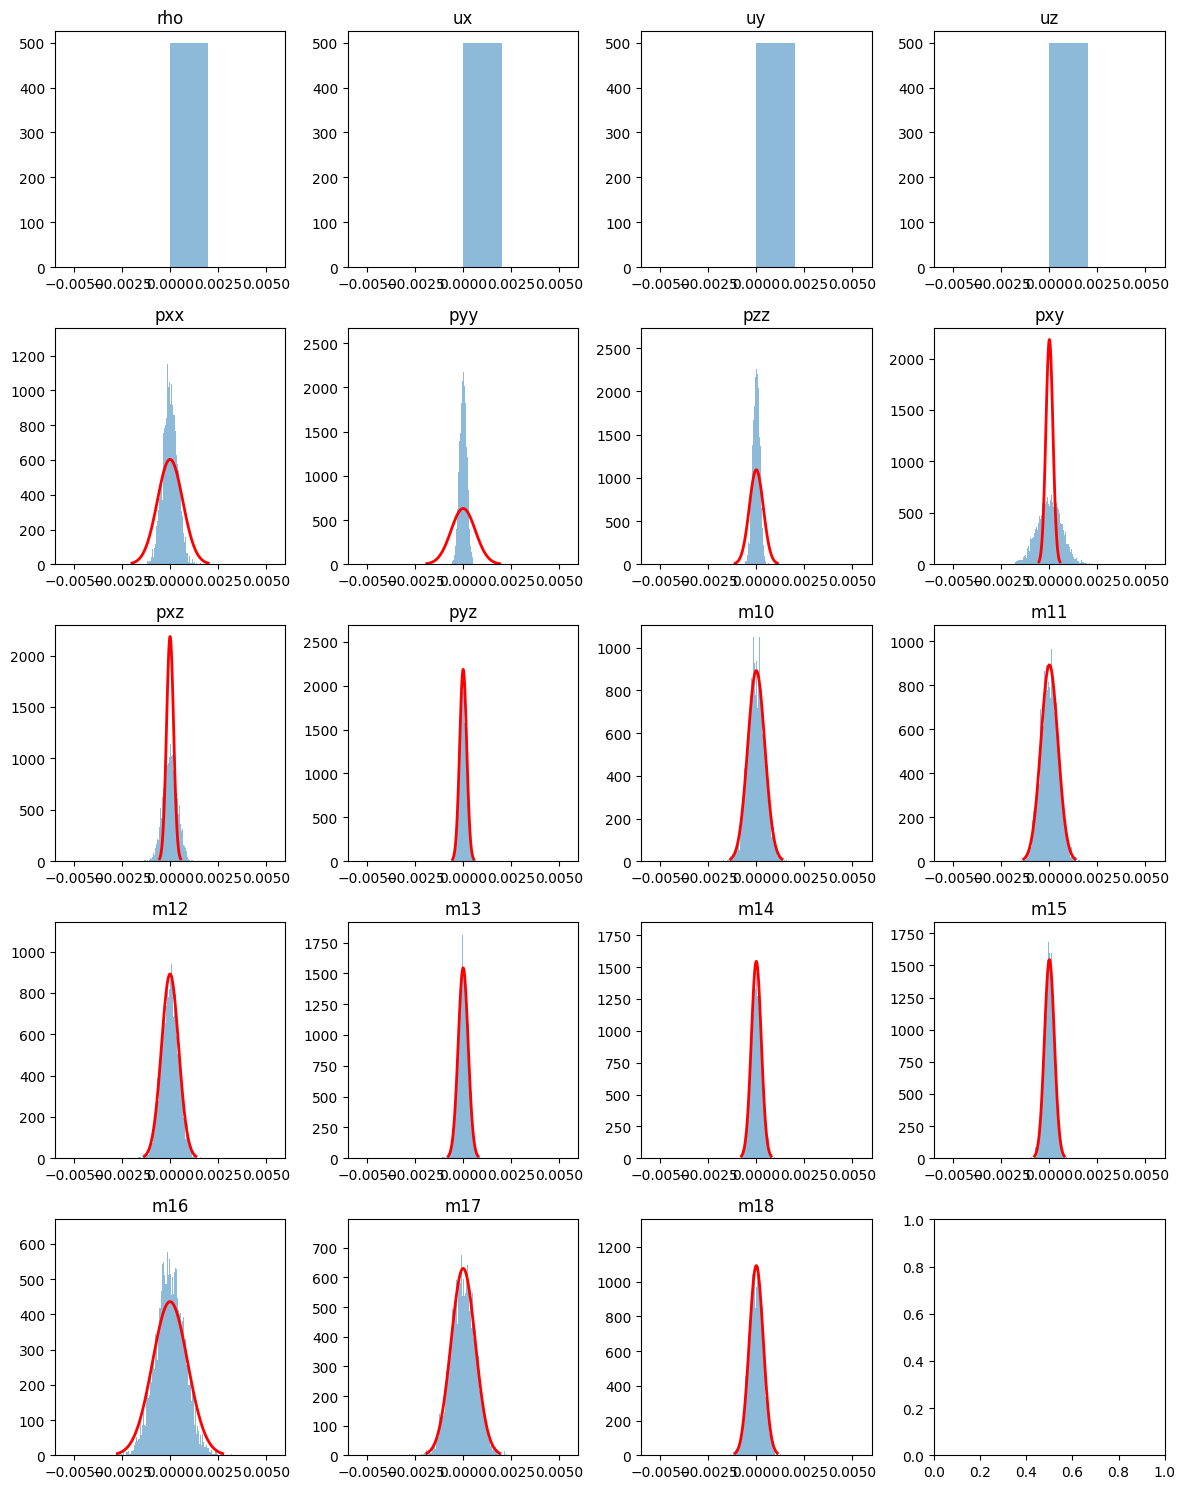

In [55]:
if check_real_space:
    rho0 = rhol
    tau = 1.0
    Lt = -1.0/tau
    La = Lt*(2 + Lt)
    Le = Lt + Lt + Lt*Lt

    mu_s = [0]*19


    system_cs2 = 2*rho0*Beta*(rhol - rhov)**2
    T = -kbt*rho0/cs2
    C = -kbt*rho0

    

    noise_variance = [0]*4 + [C*(5 - 9*system_cs2)*La] + [4*C*La] + [4/3*C*La]\
                + [1/3*C*La]*3 + [2*C*La]*3\
                + [2/3*C*La]*3 + [9*C*(1 - system_cs2)*La]\
                + [4*C*La] + [4/3*C*La]
    # noise_variance = [0]*4 + [N[4]*T*(5 - 9*system_cs2)*La] + [2*N[7]*T*La]*3\
    #             + [2*N[5]*T*La] + [2*N[6]*T*La]\
    #             + [2*N[10]*T*La]*3 + [2*N[13]*T*La]*3\
    #             + [6*N[16]*T*(1 - system_cs2)*La]\
    #             + [2*N[17]*T*La] + [2*N[18]*T*La]

    n = len(mu_s)
    rows = int(np.ceil(n/4))

    fig, axs = plt.subplots(rows, 4, figsize = (3*4, rows*3))
    axs = axs.flatten()

    for i in range(n):
        ax = axs[i]
        data = conserved_variables_data[i, ...].flatten()
        ax.hist(data, bins = 500, density = True, color = 'tab:blue', alpha = 0.5)
        sigma_real = np.std(data)

        mu = mu_s[i]
        sigma = np.sqrt(float(noise_variance[i]))
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red', lw = 2)
        print(f"{sigma_real/sigma:.3f}")

        ax.set_title(conserved_variables[i][-1])
        ax.set_xlim([mu - 0.006, mu + 0.006])

    fig.tight_layout()

### Equilibration ratios

In [165]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/cs2

def thermal_cs2(rho):
    square_term = (rho - rhol)*(rho - rhov)
    expr1 = Beta*square_term*(rhol - rhov - 6*rho)
    expr2 = Beta*(rho - rhol)*(2*rho*(rhol + rhov - 2*rho) + square_term)
    expr3 = Beta*(rho - rhov)*(2*rho*(rhol + rhov - 2*rho) + square_term)
    return -expr1 - expr2 - expr3

def cs2k(density, kx, ky, kz):
    if correlated:
        out = thermal_cs2(density) + lattice_fourier_laplacian(kx, ky, kz)*kappa*rho0
    else:
        out = thermal_cs2(density)
    return out

In [166]:
def spherically_averaged_structure_factor(data, density, scale_factor = 1, func = None, shift = True):
    L = min(data.shape)
    S = data.copy()

    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
     
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
         S = func(S, cs2k(density, kx, ky, kz))
    S /= scale_factor

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

In [167]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return r, azimuth, elevation

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def radial_equilibration(data, density, radius = 1, scale_factor = 1, func = None):
    S = data.copy()
    L = min(S.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')

    r, t, p = cart2sph(kx, ky, kz)

    if func is not None:
        S = func(S, cs2k(density, kx, ky, kz))
    S /= scale_factor

    idxs = np.isclose(r, radius, atol = 2*np.pi/L)
    t = t[idxs]
    p = p[idxs]
    out = S[idxs]

    return t, p, out

In [168]:
def spherically_averaged_shells(data, density, scale_factor = 1, func = None):
    # Calculation of frequencies 
    L = min(data.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
    k = np.stack([kx, ky, kz], axis = -1)
    k2 = np.linalg.norm(k, axis=-1)
    # output data
    bins = np.linspace(0, k2.max(), L)
    binned_data = np.zeros(L)

    if func is not None:
        data = func(data, cs2k(density, kx, ky, kz))

    # binning data
    shell = np.digitize(k2, bins = bins, right = True)
    # shell = np.where(shell == L, False, shell)
    # print(np.unique(shell))
    np.add.at(binned_data, shell, data)
    unique, counts = np.unique(shell, return_counts=True)
    normalized_data = binned_data[unique]/counts
    bins = bins[unique]

    # dividing by scale factor
    normalized_data /= scale_factor

    return bins, normalized_data

In [169]:
def make_bins(to_bin1, binsize, to_bin2 = None):
    bins = np.linspace(to_bin1.min(), to_bin1.max(), binsize)

    out1 = np.zeros(binsize)
    shell = np.digitize(to_bin1, bins = bins, right = True)
    np.add.at(out1, shell, to_bin1)
    unique, counts = np.unique(shell, return_counts=True)
    out1 = out1[unique]
    out1 /= counts

    if to_bin2 is None:
        return bins, out1
    else:
        out2 = np.zeros(binsize)
        np.add.at(out2, shell, to_bin2)
        unique, counts = np.unique(shell, return_counts=True)
        out2 = out2[unique]
        out2 /= counts
        return out1, out2

In [170]:
idx = -1
rho0 = np.array(yt.load(savedir+"reference_densities_plt").all_data()[('boxlib', 'rho')]).reshape(L, L, L)
rho_data = np.array(yt.load(savedir+"hydro_plt*")[idx].all_data()[('boxlib', 'rho')]).reshape(L, L, L) 
ts = yt.load(savedir+"SF_plt_mag*")
ds = ts[idx]
ad = ds.all_data()

yt : [INFO     ] 2024-07-23 16:44:52,913 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-07-23 16:44:52,914 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-23 16:44:52,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 16:44:52,916 Parameters: domain_right_edge         = [1. 1. 1.]


yt : [INFO     ] 2024-07-23 16:44:53,047 Parameters: current_time              = 4000.0
yt : [INFO     ] 2024-07-23 16:44:53,048 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-23 16:44:53,048 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 16:44:53,049 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-23 16:44:53,166 Parameters: current_time              = 4000.0
yt : [INFO     ] 2024-07-23 16:44:53,167 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-23 16:44:53,167 Parameters: domain_left_edge          = [-50.26548246 -50.26548246 -50.26548246]
yt : [INFO     ] 2024-07-23 16:44:53,168 Parameters: domain_right_edge         = [50.26548246 50.26548246 50.26548246]


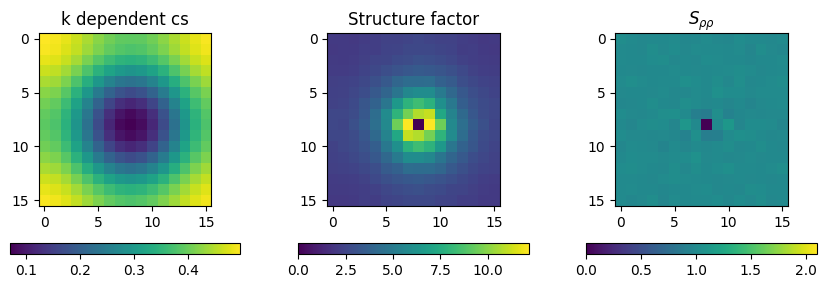

In [171]:
freqs = fft.fftshift(fft.fftfreq(L))
# freqs = fft.fftfreq(L)
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k = np.stack([kx, ky, kz], axis = -1)

fig, axs = plt.subplots(1, 3, figsize = (9, 3))

ax = axs[0]
test = cs2k(rho_data, kx, ky, kz)
im = ax.imshow(test[L//2])
plt.colorbar(im, ax = ax, orientation = 'horizontal', shrink = 0.8)
ax.set_title("k dependent cs")

ax = axs[1]
data = np.array(ad[('boxlib', 'struct_fact_rho_rho')]).reshape(L, L, L)
im = ax.imshow(data[L//2])
plt.colorbar(im, ax = ax, orientation = 'horizontal', shrink = 0.8)
ax.set_title(r"Structure factor")

ax = axs[2]
to_plot = data*test
im = ax.imshow(to_plot[L//2], vmax = 2.1)
plt.colorbar(im, ax = ax, orientation = 'horizontal', shrink = 0.8)
ax.set_title(r"$S_{\rho \rho}$")

fig.tight_layout()

In [136]:
G.diagonal()[0]

NameError: name 'G' is not defined

(0.9, 1.1)

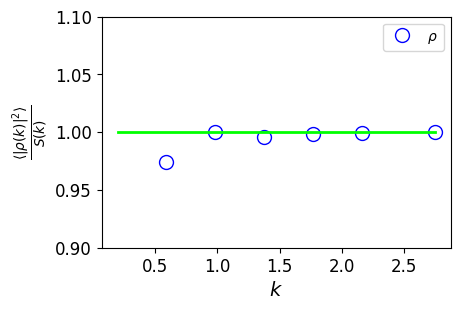

In [137]:
data = [np.array(ad[('boxlib', 'struct_fact_rho_rho')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
scale_factor = 1

for d in data:
        x, y = spherically_averaged_structure_factor(d, rho_data, scale_factor = scale_factor, func = rho_scale)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
ax.set_ylim([0.9, 1.1])

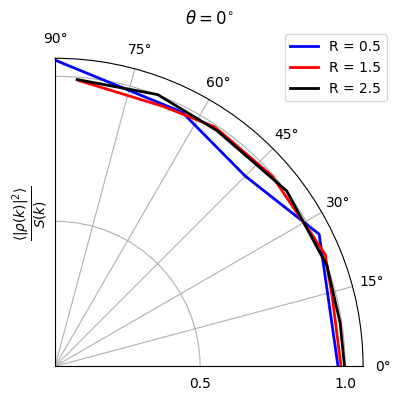

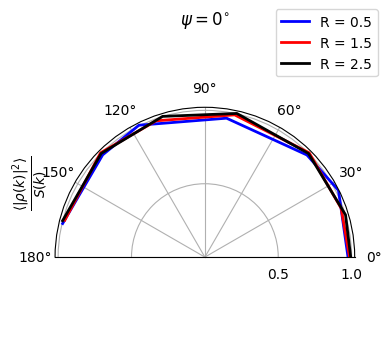

In [138]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

In [38]:
G.diagonal()[1:4]

NameError: name 'G' is not defined

(0.9, 1.1)

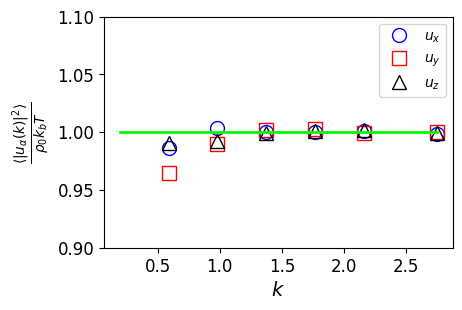

In [48]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i, d in enumerate(data):
        # x, y = spherically_averaged_shells(d)
        x, y = spherically_averaged_structure_factor(d, rho_data, scale_factor = 1)
        x, y = make_bins(x, binsize, to_bin2 = y)

        ax.plot(x, y, 
                marker = markers[i], color = colors[i],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[i])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_{0}k_b T}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
ax.set_ylim([0.9, 1.1])

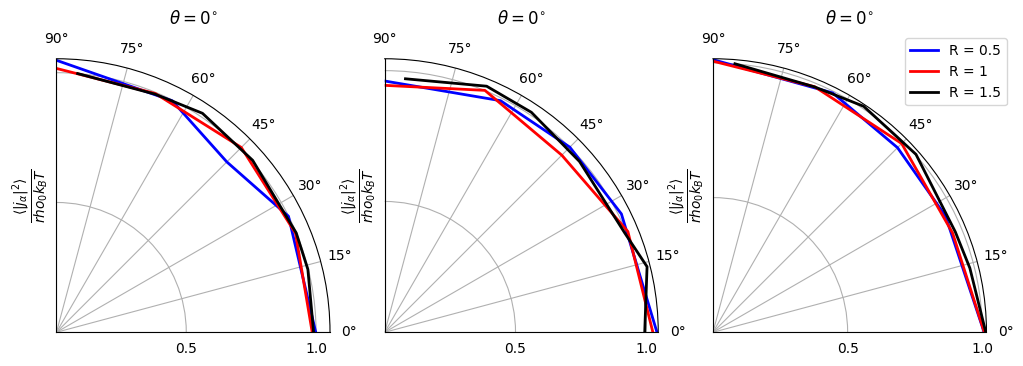

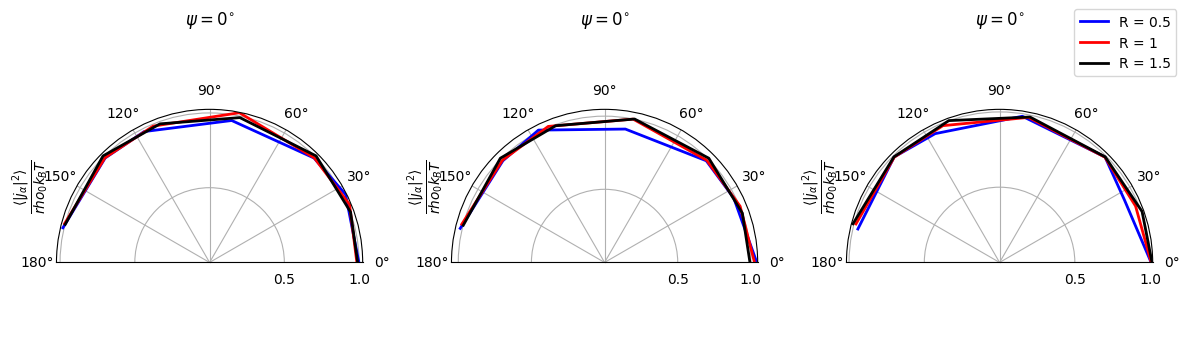

In [40]:
sz = 4
fig, tax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1, 1.5]

t_angle = 0
p_angle = 0 
# binsize = 10

for j, d in enumerate(data):
    ax1 = tax[j]
    ax2 = pax[j]
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, radius = r)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)

fig.tight_layout()

In [190]:
G.diagonal()[4:10]

[(-2*\hat{\rho}_0*c_s(k)**2 + 2*\hat{\rho}_0)*S(k)/(2*\hat{\rho}_0),
 4*S(k)*c_s(k)**2,
 4*S(k)*c_s(k)**2/3,
 S(k)*c_s(k)**2/3,
 S(k)*c_s(k)**2/3,
 S(k)*c_s(k)**2/3]

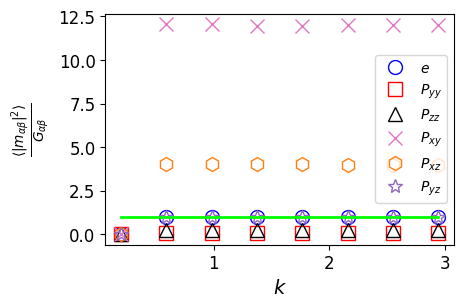

In [30]:
data = [np.array(ad[('boxlib', 'struct_fact_pxx_pxx')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_pyy_pyy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_pzz_pzz')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_pxy_pxy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_pxz_pxz')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_pyz_pyz')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k", "tab:pink", "tab:orange", "tab:purple"]
markers = ["o", "s", '^', "x", "h", "*"]
labels = [r"$e$", r"$P_{yy}$", r"$P_{zz}$", r"$P_{xy}$", r"$P_{xz}$",r"$P_{yz}$"]

scaling_functions = [lambda a, c: a*c/(1 - c), None, None, None, None, None]
scaling_factors = [1, 4, 4/3, 1/3, 1/3, 1/3]
# scaling_functions = [None, None, None, None, None, None]
# scaling_factors = [(1 - cs2)*1/cs2, 4, 4/3, 1/3, 1/3, 1/3]

# scaling_functions = np.roll(scaling_functions, shift = 2)
# scaling_factors = np.roll(scaling_factors, shift = 2)
# scaling_functions[[0, 2]] = scaling_functions[[2, 0]]
# scaling_factors[[0, 2]] = scaling_factors[[2, 0]]

for i, d in enumerate(data):
        x, y = spherically_averaged_structure_factor(d, rho_data, scale_factor = scaling_factors[i], func=scaling_functions[i])
        ax.plot(x, y, 
                marker = markers[i], color = colors[i],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[i])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
# ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | m_{\alpha \beta} | ^2 \rangle }{G_{\alpha \beta}}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()

# ax.set_ylim(0, 1.5)

## Large wavelength fluctuations at interfaces

**Settings**
1. $\rho_v = 0.5$
2. $\rho_l = 1.0$
3. $k_b T = 10^{-7}$
4. $\beta = 0.04$
5. $\kappa = 0.03$
6. $L = 128^3$
7. $t = 4\cdot10^4$

In [186]:
# savedir = "./test_interface/"
savedir = "./"
Lx = 32
Ly = 128
Lz = 128
start = 50
ideal = 0
binsize = L//4 - 1

kappa = 0.03
kbt = 1e-7
u0 = 0
cs2 = 1/3
Beta = 0.04
rhov = 0.5
rhol = 1.0
correlated = True

In [187]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/cs2

def spherically_averaged_structure_factor(data, density, scale_factor = 1, func = None, shift = True):
    L = min(data.shape)
    S = data.copy()
    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
         S = func(S, cs2k(density, kx, ky, kz))
    S /= scale_factor

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

yt : [INFO     ] 2024-07-23 17:10:15,057 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-07-23 17:10:15,059 Parameters: domain_dimensions         = [ 32 128 128]
yt : [INFO     ] 2024-07-23 17:10:15,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 17:10:15,060 Parameters: domain_right_edge         = [1. 1. 1.]


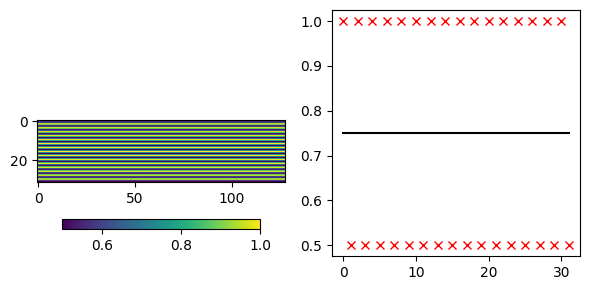

In [188]:
rho0 = np.array(yt.load(savedir+"reference_densities_plt").all_data()[('boxlib', 'rho')]).reshape(Lx, Ly, Lz)

fig, axs = plt.subplots(1, 2, figsize = (6, 3))

ax = axs[0]
im = ax.imshow(rho0[:, :, Lz//2])
plt.colorbar(im, ax = ax, orientation = "horizontal", shrink = 0.8)

ax = axs[1]
ax.plot(rho0[:, 0, Lz//2], 'rx')
ax.plot([0.75]*rho0.shape[0], 'k-')

fig.tight_layout()

In [148]:
from scipy.signal import find_peaks

def interface_height(density):
    L = min(density.shape)
    lo_min = L//4
    hi_max = 3*(L//4)

    test = density[lo_min:hi_max, :, :]
    height_func = np.zeros(test.shape[1:])

    for y in range(test.shape[1]):
        for z in range(test.shape[2]):
            slc = test[:, y, z]
            slc_grad = np.abs(np.gradient(slc))
            peak_idx = find_peaks(slc_grad, prominence=0.08)[0][0]
            height_func[y, z] = peak_idx + L//4
    return height_func


rhos = yt.load(savedir+"hydro_plt*")
heights_k = np.zeros(rho0.shape[1:], dtype = np.complex128)

for i in range(len(rhos)):
    rho = np.array(rhos[idx].all_data()[('boxlib', 'rho')]).reshape(L, L, L)
    h = interface_height(rho)
    h_k = fft.fftn(h)
    heights_k += h_k*h_k.conjugate()

heights_k = np.abs(heights_k)
heights_k /= len(rhos)

yt : [INFO     ] 2024-07-23 16:34:55,414 Parameters: current_time              = 4000.0
yt : [INFO     ] 2024-07-23 16:34:55,415 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-07-23 16:34:55,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 16:34:55,417 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-23 16:34:55,595 Parameters: current_time              = 4000.0
yt : [INFO     ] 2024-07-23 16:34:55,595 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-07-23 16:34:55,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-23 16:34:55,597 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-23 16:34:55,752 Parameters: current_time              = 4000.0
yt : [INFO     ] 2024-07-23 16:34:55,752 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-07-23 16:34:55,753 Parameters: domain_left_edge          = [0. 0. 0.]


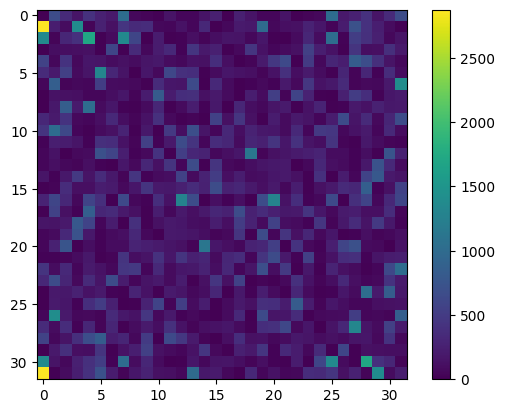

In [152]:
test = heights_k.copy()
test[0, 0] = 0

plt.imshow(test)# vmin = 62, vmax = 64)
plt.colorbar()

sigma: 1.021e-03


/tmp/ipykernel_2185626/3430395366.py:5: RuntimeWarning: divide by zero encountered in divide
  interface_fluct_theory = kbt/(sigma_theory*freqs_theory)


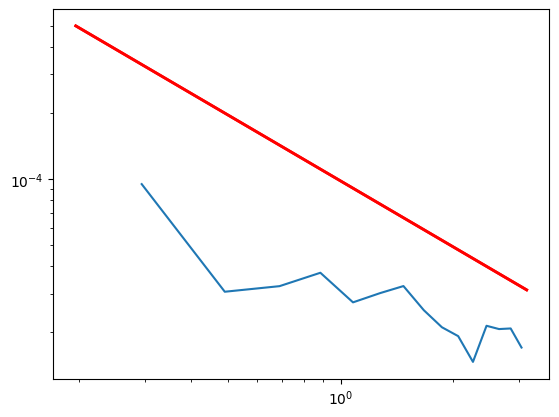

In [163]:
sigma_theory = ((rhol - rhov)**3)/6*np.sqrt(2*kappa*Beta)
int_width_theory = np.sqrt(8*kappa/Beta)*1/(rhol - rhov)

freqs_theory = np.arange(L//2 + 1)*2*np.pi/L
interface_fluct_theory = kbt/(sigma_theory*freqs_theory)

plt.loglog(freqs_theory, interface_fluct_theory, 'r-', lw = 2)
print(f"sigma: {sigma_theory:.3e}")

x_t, y_t = spherically_averaged_structure_factor(heights_k*kbt, 0, shift = False)

plt.loglog(freqs_theory, interface_fluct_theory, 'r-', lw = 2)
plt.loglog(x_t[1:], y_t[1:])
# print(f"sigma: {sigma_theory:.3e}")